<h1>Tweet Sentiment Extraction</h1>

**INTRODUCTION**

Twitter is one of the social media platforms that is being used by
people all over the world. People can tweet about a product , a person
or even about a company. Sentiment Analysis can be defined as the
process of analyzing the given text data and sorting it into positive ,
negative or neutral , so that the companies can understand how
people are talking about their band.


In this problem , we are provided with text data along with its
corresponding sentiment label (positive/negative/neutral). Our task is
to find out which of the words in the given sentence which actually
leads to the particular sentiment description. Given the labelled data,
we need to build a model to find out the words or phrases that best
support the sentiment class label.

In [1]:
#importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import re
import string
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
from nltk.corpus import stopwords
from nltk.util import ngrams
stop=set(stopwords.words('english'))
from collections import Counter

In [2]:
#importing data from csv files using Pandas
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.shape,test_df.shape

((27481, 4), (3534, 3))

In [4]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


The given dataset consists of two files namely train.csv and test.csv.
We have around 27,480 values as training data and 3534 values as a
part of test data. Training data has 4 columns namely **text_id , text ,
selected_text and sentiment.** Each text is given a unique text_id and
the phrases / words that best supports the sentiment is provided in the
sentiment_text column.


In [6]:
#Check for null values
print(train_df.isnull().sum())
print(test_df.isnull().sum())

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
textID       0
text         0
sentiment    0
dtype: int64


One of the rows in the training data contains a null values, and no null values are found in text data. We can drop the only null value row from the data

In [7]:
train_df.dropna(inplace=True)

In [8]:
#Check for null values
print(train_df.isnull().sum())
print(test_df.isnull().sum())

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64
textID       0
text         0
sentiment    0
dtype: int64


**Exploratory Data Analysis (EDA)**

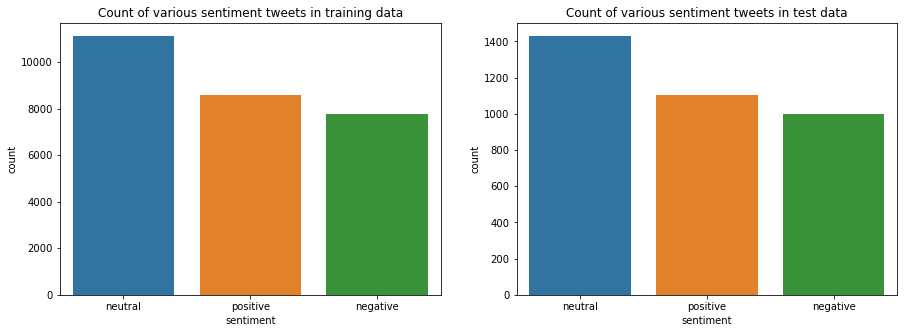

In [9]:
f, axes = plt.subplots(1, 2,figsize=(15,5))

sb.countplot(x='sentiment',data=train_df,order=train_df.sentiment.value_counts().index,ax=axes[0])\
.set_title('Count of various sentiment tweets in training data');

sb.countplot(x='sentiment',data=test_df,order=test_df.sentiment.value_counts().index,ax=axes[1]);
plt.title('Count of various sentiment tweets in test data');

From the above plot, we could conclude that both the training and test data seems to have similar kind of distributions as the majority of given data belongs to **Neutral** label in both training and test data followed by Positive and Negative labelled data points

In [10]:
def jaccard_score(x):
    str1, str2 = str(x[0]),str(x[1])
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [11]:
train_df['jaccard'] = train_df[['text','selected_text']].progress_apply(jaccard_score,axis=1)

Jaccard score is one of the metrics used to find the similarity between given two sentences. Here we are trying to calculate the Jaccard score between the text and selected_text columns, to find the similarities between the two columns

**Data Cleaning / Text Pre-processing**

In [12]:
#https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model#About-this-Notebook
#https://www.kaggle.com/raenish/tweet-sentiment-insight-eda/data

In [13]:
# Remove the text in square brackets
txt = '[start] i am not a [BAD] monster!!!'
print(re.sub('\[.*?\]', '',txt))
#remove links in given text
txt= 'http://google.com this is a http://google.com link or use www.google.com!!!'
print(re.sub('https?://\S+|www\.\S+', '', txt))
#remove text/chars within angular brackets
txt = '[start] i am not a [BAD] monster. <kill> you!!! '
print(re.sub('<.*?>+', '', txt))
#remove words containing numbers
txt = 'i am not 4yrs old , 4ever young!!!'
print(re.sub('\w*\d\w*', '', txt))
#remove expressions like \n from text
txt = 'i am a bad\n bad\n boy\n!!!'
print(re.sub('\n', '', txt))
#remove punctuations from a string
txt = "what the hell was that!!!!! you think i donno anything???  that's bad...., i ll 'GET' you and kill you**** ###"
print(re.sub('[%s]' % re.escape(string.punctuation), '', txt))

 i am not a  monster!!!
 this is a  link or use 
[start] i am not a [BAD] monster.  you!!! 
i am not  old ,  young!!!
i am a bad bad boy!!!
what the hell was that you think i donno anything  thats bad i ll GET you and kill you 


In [14]:
#text cleaning or text preprocessing
def clean_text(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [15]:
#https://towardsdatascience.com/progress-bars-in-python-and-pandas-f81954d33bae

In [16]:
train_df['text'] = train_df['text'].progress_apply(lambda x : clean_text(x))
train_df['selected_text'] = train_df['selected_text'].progress_apply(lambda x : clean_text(x))

In [17]:
test_df['text'] = test_df['text'].progress_apply(lambda x : clean_text(x))

In [18]:
train_df.isnull().sum(),test_df.isnull().sum()

(textID           0
 text             0
 selected_text    0
 sentiment        0
 jaccard          0
 dtype: int64, textID       0
 text         0
 sentiment    0
 dtype: int64)

In [19]:
train_df['text_length'] = train_df['text'].progress_apply(lambda x: len(str(x).split()))
train_df['selected_text_length'] = train_df['selected_text'].progress_apply(lambda x: len(str(x).split()))

In [20]:
test_df['text_length'] = test_df['text'].progress_apply(lambda x: len(str(x).split()))

In [21]:
train_df.head(15)

,textID,text,selected_text,sentiment,jaccard,text_length,selected_text_length
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,10,2
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,5,2
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,5,3
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,13,2
5,28b57f3990,some shameless plugging for the best rangers...,some shameless plugging for the best rangers...,neutral,1.000000,10,10
6,6e0c6d75b1,feedings for the baby are fun when he is all ...,fun,positive,0.071429,13,1
7,50e14c0bb8,soooo high,soooo high,neutral,1.000000,2,2
8,e050245fbd,both of you,both of you,neutral,1.000000,3,3
9,fc2cbefa9d,journey wow u just became cooler hehe is tha...,wow u just became cooler,positive,0.500000,10,5


In [22]:
test_df.head(15)

,textID,text,sentiment,text_length
0,f87dea47db,last session of the day,neutral,5
1,96d74cb729,shanghai is also really exciting precisely s...,positive,14
2,eee518ae67,recession hit veronique branquinho she has to ...,negative,13
3,01082688c6,happy bday,positive,2
4,33987a8ee5,i like it,positive,3
5,726e501993,thats great weee visitors,positive,4
6,261932614e,i think everyone hates me on here lol,negative,8
7,afa11da83f,soooooo wish i could but im in school and mys...,negative,13
8,e64208b4ef,and within a short time of the last clue all ...,neutral,12
9,37bcad24ca,what did you get my day is alright havent do...,neutral,18


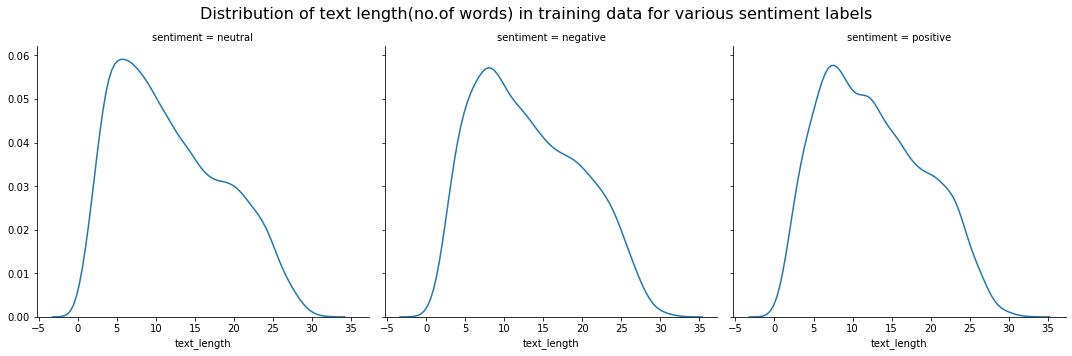

In [23]:
#https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot
g=sb.FacetGrid(data=train_df,col='sentiment',height=5);
g.map(sb.kdeplot,'text_length');
plt.subplots_adjust(top=0.87,)
g.fig.suptitle('Distribution of text length(no.of words) in training data for various sentiment labels',fontsize=16);

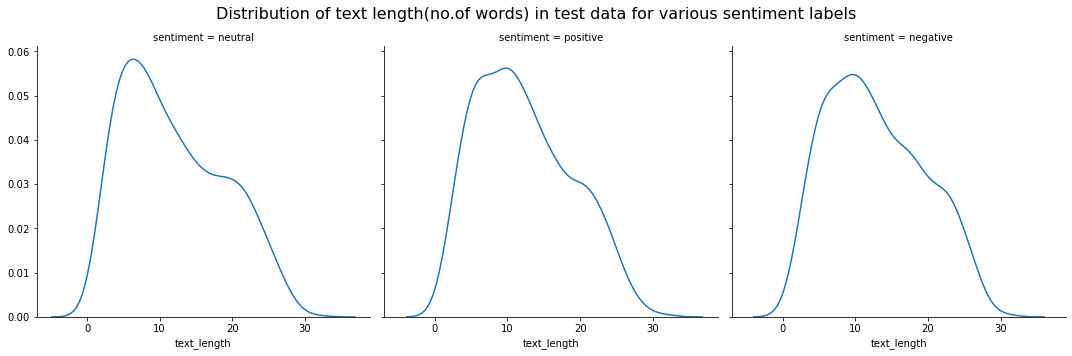

In [24]:
g=sb.FacetGrid(data=test_df,col='sentiment',height=5);
g.map(sb.kdeplot,'text_length');
plt.subplots_adjust(top=0.87,)
g.fig.suptitle('Distribution of text length(no.of words) in test data for various sentiment labels',fontsize=16);

From the above plot, we could infer that most of the texts provided in the data contains **0-20 words** and there are only very few sentences having no. of words > 25

The same text length parameter is visualized using Violin plots below

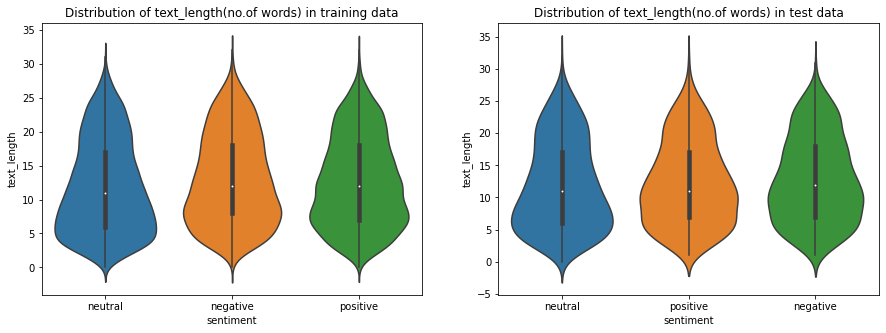

In [25]:
f, axes = plt.subplots(1, 2,figsize=(15,5))

sb.violinplot(data=train_df,y='text_length',x='sentiment',ax=axes[0])\
.set_title('Distribution of text_length(no.of words) in training data');
sb.violinplot(data=test_df,y='text_length',x='sentiment',ax=axes[1])\
.set_title('Distribution of text_length(no.of words) in test data');

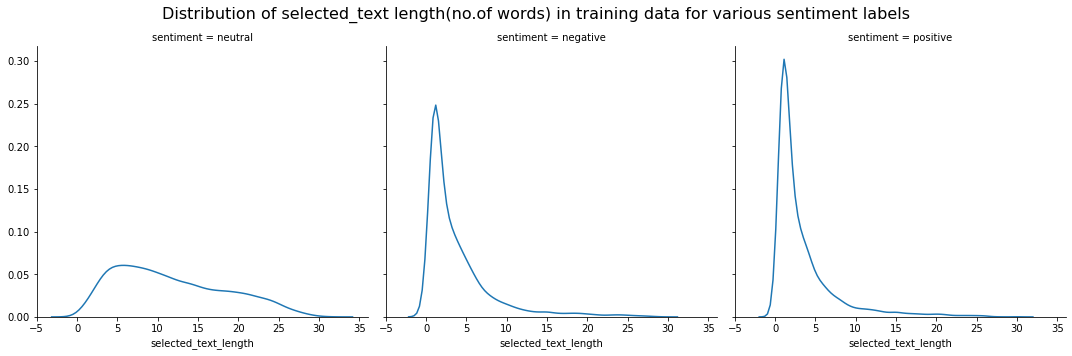

In [26]:
#https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot
g=sb.FacetGrid(data=train_df,col='sentiment',height=5);
g.map(sb.kdeplot,'selected_text_length');
plt.subplots_adjust(top=0.87,)
g.fig.suptitle('Distribution of selected_text length(no.of words) in training data for various sentiment labels',fontsize=16);

From the above plot, we can conclude that for Negative and Positive Sentiment, majority of selected_text phrases length lie **between 0-10 words**, there are only a few sentences that are greater than 10 words of length.

For Neutral sentiment, the majority of selected_text phrases are longer when compared to positive / negative sentiment labels.
Most of the phrases length lie between **0-20 words** length

In [27]:
train_df['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [28]:
positive_data =  train_df[train_df['sentiment']=='positive']
positive_data.shape

(8582, 7)

In [29]:
negative_data =  train_df[train_df['sentiment']=='negative']
negative_data.shape

(7781, 7)

In [30]:
neutral_data =  train_df[train_df['sentiment']=='neutral']
neutral_data.shape

(11117, 7)

In [31]:
positive_corpus=[]
for each in tqdm(positive_data['text'].values):
    sent = ["".join(x) for x in each.split() if x not in stop]
    positive_corpus.extend(sent)

100%|██████████████████████████████████████████████████████████████████████████| 8582/8582 [00:00<00:00, 190713.82it/s]


In [32]:
negative_corpus=[]
for each in tqdm(negative_data['text'].values):
    sent = ["".join(x) for x in each.split() if x not in stop]
    negative_corpus.extend(sent)

100%|██████████████████████████████████████████████████████████████████████████| 7781/7781 [00:00<00:00, 189778.79it/s]


In [33]:
neutral_corpus=[]
for each in tqdm(neutral_data['text'].values):
    sent = ["".join(x) for x in each.split() if x not in stop]
    neutral_corpus.extend(sent)

100%|████████████████████████████████████████████████████████████████████████| 11117/11117 [00:00<00:00, 205855.30it/s]


In [34]:
positive_corpus = pd.DataFrame(Counter(positive_corpus).most_common(),columns=['word','count'])
negative_corpus = pd.DataFrame(Counter(negative_corpus).most_common(),columns=['word','count'])
neutral_corpus = pd.DataFrame(Counter(neutral_corpus).most_common(),columns=['word','count'])

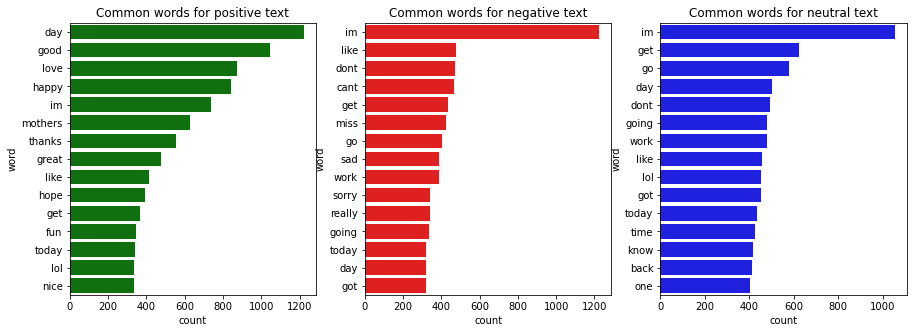

In [35]:
f, axes = plt.subplots(1, 3,figsize=(15,5))

sb.barplot(data=positive_corpus[:15],y='word',x='count',ax=axes[0],color='g')\
.set_title('Common words for positive text');
sb.barplot(data=negative_corpus[:15],y='word',x='count',ax=axes[1],color='r')\
.set_title('Common words for negative text');
sb.barplot(data=neutral_corpus[:15],y='word',x='count',ax=axes[2],color='b')\
.set_title('Common words for neutral text');

The above plot shows the most common 15 words that are present in the text for various sentiment labels

In [36]:
positive_corpus1=[]
for each in tqdm(positive_data['selected_text'].values):
    sent = ["".join(x) for x in each.split() if x not in stop]
    positive_corpus1.extend(sent)

negative_corpus1=[]
for each in tqdm(negative_data['selected_text'].values):
    sent = ["".join(x) for x in each.split() if x not in stop]
    negative_corpus1.extend(sent) 
    
neutral_corpus1=[]
for each in tqdm(neutral_data['selected_text'].values):
    sent = ["".join(x) for x in each.split() if x not in stop]
    neutral_corpus1.extend(sent)    
    
    
positive_corpus1 = pd.DataFrame(Counter(positive_corpus1).most_common(),columns=['word','count'])
negative_corpus1 = pd.DataFrame(Counter(negative_corpus1).most_common(),columns=['word','count'])
neutral_corpus1 = pd.DataFrame(Counter(neutral_corpus1).most_common(),columns=['word','count'])    

100%|████████████████████████████████████████████████████████████████████████| 11117/11117 [00:00<00:00, 213783.37it/s]


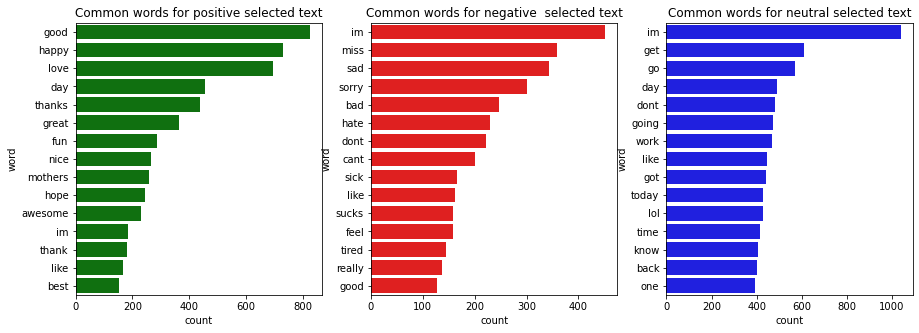

In [37]:
f, axes = plt.subplots(1, 3,figsize=(15,5))

sb.barplot(data=positive_corpus1[:15],y='word',x='count',ax=axes[0],color='g')\
.set_title('Common words for positive selected text');
sb.barplot(data=negative_corpus1[:15],y='word',x='count',ax=axes[1],color='r')\
.set_title('Common words for negative  selected text');
sb.barplot(data=neutral_corpus1[:15],y='word',x='count',ax=axes[2],color='b')\
.set_title('Common words for neutral selected text');

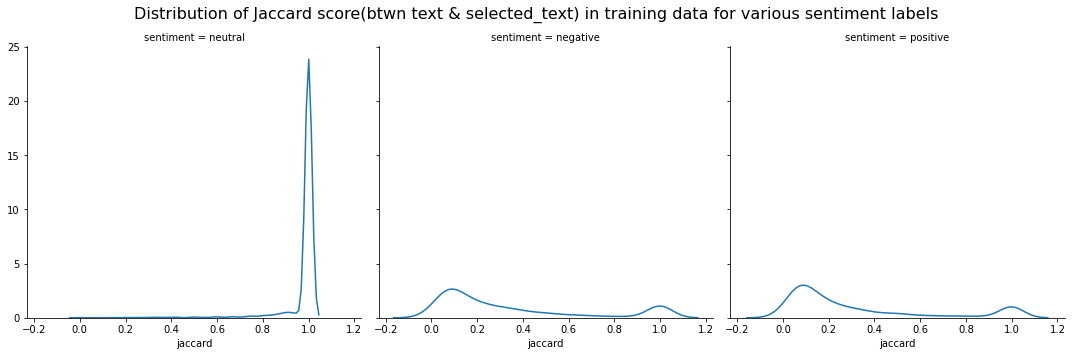

In [46]:
g=sb.FacetGrid(data=train_df,col='sentiment',height=5);
g.map(sb.kdeplot,'jaccard');
plt.subplots_adjust(top=0.87,)
g.fig.suptitle('Distribution of Jaccard score(btwn text & selected_text) in training data for various sentiment labels',fontsize=16);

The above plot gives some very interesting insights

 - There is a huge spike around 1.0 for neutral sentiments , which means that most of the selected_text phrases for the neutral sentiment labels are the text sentennces itself, i.e both the text and selected_text values are same for most of the neutral sentiment data
 - For both Positive and Negative sentiment labels, we could see two spikes in the graph, one at around 0.1 or 0.15 and other around 1.0. The spike around 0.1/0.15 suggests that the similarity between text and selected_text is very low. i.e given a text, only a few words/phrases are considered as selected_text.